# Import librairies

In [1]:
import psycopg2 as ps
import pandas.io.sql as sqlio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Import Cross Validation librairies
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# Import SMOTE librairies
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import KMeansSMOTE

# Import tools
%run ../Tools.ipynb

# Connect to database

In [2]:
conn = ps.connect(dbname="SLA", user="postgres", password="root", host="localhost", port="5432")

# Get data from database

In [3]:
# Set variables
variables = ['CVF_1', 'ALS_1', 'WEIGHT_1', 'AGE_DEBUT', 'DIAG_DCD_M18']

# Set sql query
sql = 'SELECT * FROM "PATIENTS"'

# Get data from database
df_patients = sqlio.read_sql_query(sql, conn)[variables].copy()
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 1045


C:\Users\guill\anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


# Drop null values

In [4]:
# Drop null values
df_patients = df_patients.dropna().copy()
print("Nombre de patients restant :", df_patients.shape[0])

Nombre de patients restant : 326


# Separate features and target

In [5]:
# Get features
X = df_patients.drop(df_patients.columns.values[-1], axis=1)

# Get target
y = df_patients[df_patients.columns.values[-1]]

# Encode data

In [6]:
X = encodeData(X)

# Scale data

In [7]:
# Normalize data
X_scaled = (X - X.min())/ (X.max() - X.min())

# Execute Decision Tree Classifier

## Set up

In [8]:
# Set test size
test_size = 0.2

# Set number of iterations
n_repeats = 100

# Set number of splits
n_splits = 10

# Set max depth
depth = 3

# Criterion
criterion = "gini"

# Use of cross Validation
useCrossValidation = False

## Execute classifier

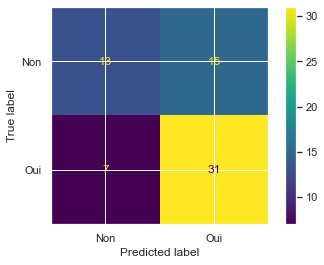

accuracy : 0.6666666666666666
recall : 0.8157894736842105
Fmeasure : 0.7337278106508874


NameError: name 'plotTree' is not defined

In [9]:
# Arrays that contains computed metrics from the model
accuracies = []
recalls = []
Fmeasures = []

# If no use of cross Validation
if useCrossValidation == False:

    # For each iterations
    for z in range(1, n_repeats):

        # Split dataset into train and test
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size)

        # Train model
        clf = DecisionTreeClassifier(max_depth=depth, criterion="gini")
        clf.fit(X_train, y_train)

        # Predict target based on test data
        y_pred = clf.predict(X_test)

        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Compute accuracy
        accuracy = clf.score(X_test, y_test)

        # Compute recall
        recall = computeRecall(cm)

        # Compute F score
        Fmeasure = computeFmeasure(accuracy, recall)

        # Append computed metrics to temporary arrays
        accuracies.append(accuracy)
        recalls.append(recall)
        Fmeasures.append(Fmeasure)

# If use of cross Validation
else:

    # Set temporary X and y train
    X_train = X.copy()
    y_train = y.copy()

    # Map target labels to 1 or 0
    y_train = y_train.map({'Oui': 1, 'Non': 0}).astype(int)

    cv = RepeatedKFold(n_splits = n_splits, n_repeats= n_repeats)
    clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion)

    # getting metrics values
    accuracies = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, error_score="raise")
    recalls = cross_val_score(clf, X_train, y_train, scoring='recall', cv=cv, error_score="raise")
    Fmeasures = cross_val_score(clf, X_train, y_train, scoring='f1', cv=cv, error_score="raise")

# Compute averaged metrics
avg_accuracy = np.mean(accuracies)
avg_recall = np.mean(recalls)
avg_Fmeasure = np.mean(Fmeasures)

# Compute standard deviation
std_accuracy = np.std(accuracies)
std_recall = np.std(recalls)
std_Fmeasure = np.std(Fmeasures)

# Plot a Confusion Matrix example with metric results
if useCrossValidation == False:
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
    display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print("accuracy :", accuracy)
    print("recall :", recall)
    print("Fmeasure :", Fmeasure)
    plotTree(clf, X.columns.values, 15, 25, 8, clf.classes_)

## Display metrics results

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

color = ['red', 'green', 'blue']

text = 'Survival Prediction : Decision Tree Classifier results '

if useCrossValidation:
    text += 'using Cross-Validation '

plt.suptitle(text, fontsize=15)

ax1.bar(["Accuracy", "Recall", "Fmeasure"], [avg_accuracy, avg_recall, avg_Fmeasure], color=color)
ax1.set_title("Average metrics")
ax1.set_ybound(upper=1)

ax2.bar(["Accuracy", "Recall", "Fmeasure"], [std_accuracy, std_recall, std_Fmeasure], color=color)
ax2.set_title("Standard deviation metrics")
ax2.set_ybound(upper=0.30)

plt.show()

# Execute Decision Tree Classifier based on differents depths

## Set up

In [10]:
avg_accuracies = []
avg_recalls = []
avg_Fmeasures = []

std_accuracies = []
std_recalls = []
std_Fmeasures = []

depths = []

# Set test size
test_size = 0.2

# Set number of iterations
n_repeats = 100

# Set number of splits
n_splits = 5

start_depth = 3
end_depth = 15

# Criterion
criterion = "gini"

# Use of cross Validation
useCrossValidation = False

## Execute classifier

In [11]:
# For each depth
for i in range(start_depth, end_depth + 1):

    depths.append(i)

    # Arrays that contains computed metrics from the model
    accuracies = []
    recalls = []
    Fmeasures = []

    # If no use of cross Validation
    if useCrossValidation == False:

        # For each iterations
        for z in range(1, n_repeats):

            # Split dataset into train and test
            X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = test_size)

            # Train model
            clf = DecisionTreeClassifier(max_depth=depth, criterion="gini")
            clf.fit(X_train, y_train)

            # Predict target based on test data
            y_pred = clf.predict(X_test)

            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)

            # Compute accuracy
            accuracy = clf.score(X_test, y_test)

            # Compute recall
            recall = computeRecall(cm)

            # Compute F score
            Fmeasure = computeFmeasure(accuracy, recall)

            # Append computed metrics to temporary arrays
            accuracies.append(accuracy)
            recalls.append(recall)
            Fmeasures.append(Fmeasure)

    # If use of cross Validation
    else:

        # Set temporary X et y train
        X_train = X.copy()
        y_train = y.copy()

        # Map target labels to 1 or 0
        y_train = y_train.map({'Oui': 1, 'Non': 0}).astype(int)
        
        # Make Cross-Validation
        cv = RepeatedKFold(n_splits = n_splits, n_repeats= n_repeats)
        clf = DecisionTreeClassifier(max_depth=depth, criterion=criterion)

        # getting metrics values
        accuracies = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, error_score="raise")
        recalls = cross_val_score(clf, X_train, y_train, scoring='recall', cv=cv, error_score="raise")
        Fmeasures = cross_val_score(clf, X_train, y_train, scoring='f1', cv=cv, error_score="raise")

    # Compute averaged metrics
    avg_accuracy = np.mean(accuracies)
    avg_recall = np.mean(recalls)
    avg_Fmeasure = np.mean(Fmeasures)
    avg_accuracies.append(avg_accuracy)
    avg_recalls.append(avg_recall)
    avg_Fmeasures.append(avg_Fmeasure)

    # Compute standard deviation
    std_accuracy = np.std(accuracies)
    std_recall = np.std(recalls)
    std_Fmeasure = np.std(Fmeasures)
    std_accuracies.append(std_accuracy)
    std_recalls.append(std_recall)
    std_Fmeasures.append(std_Fmeasure)

## Display metrics results

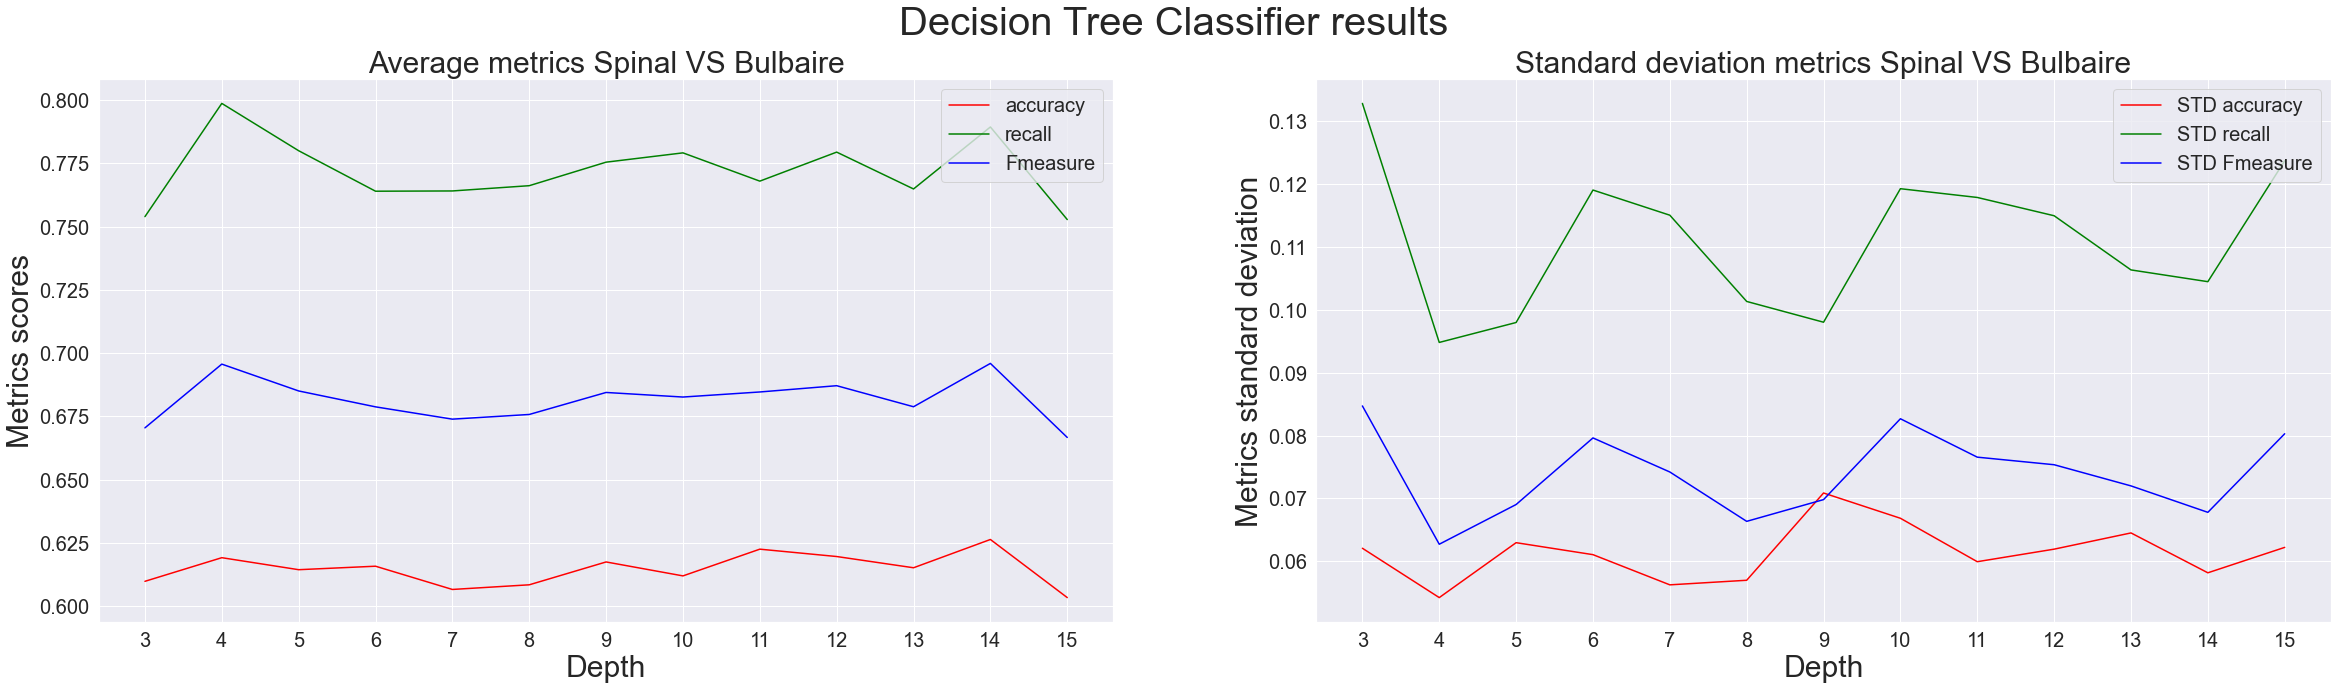

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 10))

text = 'Decision Tree Classifier results '

if useCrossValidation:
    text += 'Using Cross Validation '

plt.suptitle(text, fontsize=40)

ax1.plot(depths, avg_accuracies, color="red", label="accuracy")
ax1.plot(depths, avg_recalls, color="green", label="recall")
ax1.plot(depths, avg_Fmeasures, color="blue", label="Fmeasure")

ax1.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax1.set_xticks(depths)
ax1.set_xlabel("Depth", fontsize=30)
ax1.set_ylabel("Metrics scores", fontsize=30)
ax1.tick_params(axis="both", labelsize=20)
ax1.set_title("Average metrics Spinal VS Bulbaire", fontsize=30)

ax2.plot(depths, std_accuracies, color="red", label="STD accuracy")
ax2.plot(depths, std_recalls, color="green", label="STD recall")
ax2.plot(depths, std_Fmeasures, color="blue", label="STD Fmeasure")

ax2.legend(loc="upper right", title="", frameon=True, fontsize = 20)
ax2.set_xticks(depths)
ax2.set_xlabel("Depth", fontsize=30)
ax2.set_ylabel("Metrics standard deviation", fontsize=30)
ax2.tick_params(axis="both", labelsize=20)
ax2.set_title("Standard deviation metrics Spinal VS Bulbaire", fontsize=30)

plt.show()